In [2]:
import torch
import torch.nn as nn
import torch_geometric
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader
from torch_geometric.utils import dense_to_sparse
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim import Adam
from matplotlib import pyplot as plt
import json
import os

c:\Users\Carlos\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Carlos\anaconda3\envs\pytorch\lib\site-packages\torch_geometric\typing.py:72: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not find module 'C:\Users\Carlos\anaconda3\envs\pytorch\Lib\site-packages\torch_scatter\_scatter_cuda.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


 Similarity metrics

In [3]:
# PyTorch implementations of Polynomial Kernels

def polynomial_kernel(X, Y, degree=2, gamma=1.0, coef0=1.0):
    """
    Polynomial kernel function.
    :param X: torch.Tensor of shape (n_samples_1, n_features)
    :param Y: torch.Tensor of shape (n_samples_2, n_features)
    :param degree: int, default=2
    :param gamma: float, default=1.0
    :param coef0: float, default=1.0
    :return: torch.Tensor of shape (n_samples_1, n_samples_2)
    """
    K = (gamma * torch.mm(X, Y.t()) + coef0) ** degree
    return K

def rbf_kernel(X, Y, gamma=None):

    """
    Rbf kernel function.
    :param X: torch.Tensor of shape (n_samples_1, n_features)
    :param Y: torch.Tensor of shape (n_samples_2, n_features)
    :param gamma: float or None, default=None
    :return: torch.Tensor of shape (n_samples_1, n_samples_2)
    """

    if gamma == None:
        gamma = 1.0/X.size(1) # gamma = 1/n_features
    
    # K(x, y) = exp(-gamma ||x-y||^2)
    d_XY = torch.cdist(X, Y, p=2) # pairwise distances between X and Y rows. Shape = (n_samples_1, n_samples_2)
    K = torch.exp(-gamma * d_XY ** 2)

    return K

def laplacian_kernel(X, Y, gamma=None):
    """
    Laplacian kernel function.
    :param X: torch.Tensor of shape (n_samples_1, n_features)
    :param Y: torch.Tensor of shape (n_samples_2, n_features)
    :param gamma: float or None, default=None
    :return: torch.Tensor of shape (n_samples_1, n_samples_2)
    """

    if gamma == None:
        gamma = 1.0/X.size(1) # gamma = 1/n_features
    
    # K(x, y) = exp(-gamma ||x-y||)
    d_XY = torch.cdist(X, Y, p=1) # pairwise distances between X and Y rows. Shape = (n_samples_1, n_samples_2)
    K = torch.exp(-gamma * d_XY)

    return K

def sigmoid_kernel(X, Y, gamma=1.0, coef0=1.0):
    """
    Sigmoid kernel function.
    :param X: torch.Tensor of shape (n_samples_1, n_features)
    :param Y: torch.Tensor of shape (n_samples_2, n_features)
    :param gamma: float, default=1.0
    :param coef0: float, default=1.0
    :return: torch.Tensor of shape (n_samples_1, n_samples_2)
    """
    K = torch.tanh(gamma * torch.mm(X, Y.t()) + coef0)
    return K


In [15]:
def binary_distance(X, Y):
    """Compute distance matrix between  rows of X, Y.

    d(x_i, y_j) = 1 if x_i == y_j, 0 in other case.

    for all rows x_i in X, y_j in Y

    """
    return (X.unsqueeze(1) == Y.unsqueeze(0)).all(-1).float()


def kernel(X, *args, **kwargs):
    """
    Compute similarity matrix of an array X using a variety of kernels
    Parameters:
        X = input data (torch.Tensor or numpy array)
    """
    # kernel parameters

    degree = kwargs.get("degree", None)
    gamma = kwargs.get("gamma", None)
    coef = kwargs.get("coef", None)
    kernel_type = kwargs.get("kernel_type", None)

    if kernel_type == "polynomial":


        # K(x,y) = (gamma * <x,y> + coef)^degree, for vectors x,y

        if (gamma != None) & (coef != None) & (degree != None):
            return polynomial_kernel(X = X, Y = X, degree = degree, gamma = gamma, coef0 = coef)
        else:
            return None

    elif kernel_type == "sigmoid":
 
        # K(x,y) = tanh(gamma * <x,y> + coef), for vectors x,y

        if (gamma != None) & (coef != None):
            return sigmoid_kernel(X = X, Y = X, gamma = gamma, coef0 = coef)
        else:
            return None

    elif kernel_type == "rbf":

        # K(x, y) = exp(-gamma ||x-y||^2)

        if (gamma != None):
            return rbf_kernel(X = X, Y = X, gamma = gamma)
        else:
            return None

    elif kernel_type == "laplacian":

        # K(x, y) = exp(-gamma ||x-y||_1)

        if (gamma != None):
            return laplacian_kernel(X = X, Y = X, gamma = gamma)
        else:
            return None

    else:
        return None


Model definition

In [21]:
class Encoder(nn.Module):
    def __init__(self, input_size, latent_size):
        super().__init__()
        self.layer1 = GCNConv(input_size, latent_size)
        
        self.activation = nn.LeakyReLU()
    def forward(self, x):
        x = self.activation(self.layer1(x))
        return x

class Encoder_graph_triplet_loss(nn.Module):
    def __init__(self, encoder, kernel_parameters_X, optimizer, label_indep = False, kernel_parameters_Y = None, gamma = 0.1):
        super().__init__()
        self.encoder = encoder
        self.kernel_parameters_X = kernel_parameters_X
        self.optimizer = optimizer
        self.label_indep = label_indep
        self.kernel_parameters_Y = kernel_parameters_Y
        self.gamma = gamma
    
    def encode(self, x):
        return self.encoder(x)
    
    def train_model(self, data_loader):
        self.train()
        
        epoch_losses = []

        for X, y in tqdm(data_loader):
            self.optimizer.zero_grad()
            Z = self.encode(X)

            # Calculation of similarity matrices

            K_Z = kernel(Z, **self.kernel_parameters_X)
            K_X = kernel(X, **self.kernel_parameters_X)
            d_Z = torch.cdist(Z, Z, p=2)
            if self.label_indep: # data with different labels has not relationship (e.g: multiclass classification)
                K_Y = binary_distance(y.unsqueeze(1), y.unsqueeze(1))
            else:
                if self.kernel_parameters_Y == None:
                    self.kernel_parameters_Y = self.kernel_parameters_X
                K_Y = kernel(y, **self.kernel_parameters_Y)
            
            loss = torch.sum(K_X * K_Y * d_Z)
            epoch_losses.append(loss)

            loss.backward()
            self.optimizer.step()
        
        avg_loss = torch.mean(torch.Tensor(epoch_losses))
        return avg_loss.item()
    
    def test_model(self, data_loader):
        self.eval()
        epoch_losses = []

        with torch.no_grad():
            for X, y in data_loader:
                Z = self.encode(X)

                # Calculation of similarity matrices

                K_Z = kernel(Z, **self.kernel_parameters_X)
                K_X = kernel(X, **self.kernel_parameters_X)
                d_Z = torch.cdist(Z, Z, p=2)
                if self.label_indep: # data with different labels has not relationship (e.g: multiclass classification)
                    K_Y = binary_distance(y.unsqueeze(1), y.unsqueeze(1))
                else:
                    if self.kernel_parameters_Y == None:
                        self.kernel_parameters_Y = self.kernel_parameters_X
                    K_Y = kernel(y, **self.kernel_parameters_Y)
            
                loss = torch.sum(K_X * K_Y * d_Z)
                epoch_losses.append(loss)
            
        avg_loss = torch.mean(torch.Tensor(epoch_losses))
        return avg_loss.item()
            
            

    


Model hyperparameters

In [22]:
lr = 0.001 # learning rate
batch_size = 64
epochs = 1000
latent_size = 64 # latent space dimension

kernel_param_X = {

    "kernel_type": "rbf",
    "degree": 3,
    "gamma": 1e-2,
    "coef": 0.5e2

}

# kernel function parameters for Y_train / Y_test. If is equal to None, we use the same parameters.

kernel_param_Y = None

"""
kernel_param_Y = {

    "kernel_type": "polynomial",
    "degree": 3,
    "gamma": 1.,
    "coef": 1.

}
"""

label_indep = True # True for categoric labels, False for numerical labels

MNIST Fashion preprocessing

In [ ]:
# !git clone "https://github.com/Carlosespicur/tfm_esteban"

In [7]:


# train_data = pd.read_csv("/content/tfm_esteban/fashion_MNIST/fashion-mnist_train.csv")
# test_data = pd.read_csv("/content/tfm_esteban/fashion_MNIST/fashion-mnist_test.csv")

train_data = pd.read_csv("fashion_MNIST/fashion-mnist_train.csv")
test_data = pd.read_csv("fashion_MNIST/fashion-mnist_test.csv")
data = pd.concat([train_data, test_data], ignore_index = True)
# print(train_data.shape, test_data.shape, data.shape)
# data.head()
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, stratify=data["label"], random_state=20)
train_data, val_data = train_test_split(train_data, test_size=0.1, shuffle=True, stratify=train_data["label"], random_state=20)

# print(train_data["label"].value_counts(normalize=True))
# print(val_data["label"].value_counts(normalize=True))
# print(test_data["label"].value_counts(normalize=True))

X_train = np.array(train_data.drop("label", axis = 1, inplace=False))/255
X_train = torch.tensor(X_train, dtype = torch.float)
y_train = train_data["label"].values
y_train = torch.tensor(y_train, dtype = torch.float)
X_val = np.array(val_data.drop("label", axis = 1, inplace=False))/255
X_val = torch.tensor(X_val, dtype = torch.float)
y_val = val_data["label"].values
y_val = torch.tensor(y_val, dtype = torch.float)
X_test = np.array(test_data.drop("label", axis = 1, inplace=False))/255
X_test = torch.tensor(X_test, dtype = torch.float)
y_test = test_data["label"].values
y_test = torch.tensor(y_test, dtype = torch.float)

train_loader = DataLoader(list(zip(X_train, y_train)), shuffle = True, batch_size=batch_size)
val_loader = DataLoader(list(zip(X_val, y_val)), shuffle = True, batch_size=batch_size)
test_loader = DataLoader(list(zip(X_test, y_test)), shuffle = False, batch_size=batch_size)

input_size = X_train.size(1)

In [ ]:
# # PRUEBA CON DATASET ORIGINAL 

# # train_data = pd.read_csv("/content/tfm_esteban/fashion_MNIST/fashion-mnist_train.csv")
# # test_data = pd.read_csv("/content/tfm_esteban/fashion_MNIST/fashion-mnist_test.csv")

# train_data = pd.read_csv("../datasets/fashion_MNIST/fashion-mnist_train.csv")
# test_data = pd.read_csv("../datasets/fashion_MNIST/fashion-mnist_test.csv")
# # data = pd.concat([train_data, test_data], ignore_index = True)
# # print(train_data.shape, test_data.shape, data.shape)
# # data.head()
# # train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, stratify=data["label"], random_state=20)
# train_data, val_data = train_test_split(train_data, test_size=0.1, shuffle=True, stratify=train_data["label"], random_state=20)

# # print(train_data["label"].value_counts(normalize=True))
# # print(val_data["label"].value_counts(normalize=True))
# # print(test_data["label"].value_counts(normalize=True))

# X_train = np.array(train_data.drop("label", axis = 1, inplace=False))/255
# X_train = torch.tensor(X_train, dtype = torch.float)
# y_train = train_data["label"].values
# y_train = torch.tensor(y_train, dtype = torch.float)
# X_val = np.array(val_data.drop("label", axis = 1, inplace=False))/255
# X_val = torch.tensor(X_val, dtype = torch.float)
# y_val = val_data["label"].values
# y_val = torch.tensor(y_val, dtype = torch.float)
# X_test = np.array(test_data.drop("label", axis = 1, inplace=False))/255
# X_test = torch.tensor(X_test, dtype = torch.float)
# y_test = test_data["label"].values
# y_test = torch.tensor(y_test, dtype = torch.float)

# train_loader = DataLoader(list(zip(X_train, y_train)), shuffle = True, batch_size=batch_size)
# val_loader = DataLoader(list(zip(X_val, y_val)), shuffle = True, batch_size=batch_size)
# test_loader = DataLoader(list(zip(X_test, y_test)), shuffle = False, batch_size=batch_size)

# input_size = X_train.size(1)

Model creation

In [23]:
encoder = Encoder(input_size, latent_size)
optimizer = Adam(list(encoder.parameters()), lr = lr)

model = Encoder_graph_triplet_loss(encoder, kernel_param_X, optimizer, label_indep, kernel_param_Y, gamma = 0.2)



Model training

In [24]:
for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}/{epochs}")
    avg_loss_train = model.train_model(train_loader)
    avg_loss_val = model.test_model(val_loader)

    print(f"avg_loss_train: {avg_loss_train}")
    print(f"avg_loss_val: {avg_loss_val}")


Epoch: 1/1000


100%|██████████| 788/788 [00:19<00:00, 39.58it/s]


avg_loss_train: 0.341322660446167
avg_loss_val: 0.026273531839251518
Epoch: 2/1000


100%|██████████| 788/788 [00:20<00:00, 39.40it/s]


avg_loss_train: 0.015629012137651443
avg_loss_val: 0.05184765160083771
Epoch: 3/1000


100%|██████████| 788/788 [00:19<00:00, 39.68it/s]


avg_loss_train: 0.011789729818701744
avg_loss_val: 0.0071005914360284805
Epoch: 4/1000


100%|██████████| 788/788 [00:19<00:00, 39.51it/s]


avg_loss_train: 0.008824305608868599
avg_loss_val: 0.0016518216580152512
Epoch: 5/1000


100%|██████████| 788/788 [00:19<00:00, 39.77it/s]


avg_loss_train: 0.0061372313648462296
avg_loss_val: 0.005133293569087982
Epoch: 6/1000


100%|██████████| 788/788 [00:19<00:00, 39.48it/s]


avg_loss_train: 0.0094786137342453
avg_loss_val: 0.0051240697503089905
Epoch: 7/1000


100%|██████████| 788/788 [00:19<00:00, 39.46it/s]


avg_loss_train: 0.005819648504257202
avg_loss_val: 0.006587706971913576
Epoch: 8/1000


100%|██████████| 788/788 [00:19<00:00, 39.45it/s]


avg_loss_train: 0.005568081978708506
avg_loss_val: 0.003907488659024239
Epoch: 9/1000


100%|██████████| 788/788 [00:19<00:00, 39.91it/s]


avg_loss_train: 0.004440057557076216
avg_loss_val: 0.003238046308979392
Epoch: 10/1000


100%|██████████| 788/788 [00:19<00:00, 39.77it/s]


avg_loss_train: 0.0034471601247787476
avg_loss_val: 0.00370758306235075
Epoch: 11/1000


100%|██████████| 788/788 [00:20<00:00, 39.30it/s]


avg_loss_train: 0.0031158174388110638
avg_loss_val: 0.0038517480716109276
Epoch: 12/1000


100%|██████████| 788/788 [00:19<00:00, 39.97it/s]


avg_loss_train: 0.0008865422569215298
avg_loss_val: 0.0001803260820452124
Epoch: 13/1000


100%|██████████| 788/788 [00:19<00:00, 39.58it/s]


avg_loss_train: 0.00017460207163821906
avg_loss_val: 0.00017368001863360405
Epoch: 14/1000


100%|██████████| 788/788 [00:19<00:00, 40.10it/s]


avg_loss_train: 0.061942968517541885
avg_loss_val: 0.06279008835554123
Epoch: 15/1000


100%|██████████| 788/788 [00:19<00:00, 39.73it/s]


avg_loss_train: 0.007761178072541952
avg_loss_val: 0.0033460960257798433
Epoch: 16/1000


100%|██████████| 788/788 [00:20<00:00, 39.28it/s]


avg_loss_train: 0.002882987493649125
avg_loss_val: 0.0019799498841166496
Epoch: 17/1000


100%|██████████| 788/788 [00:19<00:00, 39.84it/s]


avg_loss_train: 0.002332074800506234
avg_loss_val: 0.002027178416028619
Epoch: 18/1000


100%|██████████| 788/788 [00:19<00:00, 39.52it/s]


avg_loss_train: 0.0019730140920728445
avg_loss_val: 0.0028047028463333845
Epoch: 19/1000


100%|██████████| 788/788 [00:19<00:00, 39.62it/s]


avg_loss_train: 0.001595434034243226
avg_loss_val: 0.002944067120552063
Epoch: 20/1000


100%|██████████| 788/788 [00:19<00:00, 39.90it/s]


avg_loss_train: 0.0012223623925819993
avg_loss_val: 0.0016779855359345675
Epoch: 21/1000


100%|██████████| 788/788 [00:20<00:00, 38.50it/s]


avg_loss_train: 0.0008968512993305922
avg_loss_val: 0.0007694898522458971
Epoch: 22/1000


100%|██████████| 788/788 [00:19<00:00, 39.93it/s]


avg_loss_train: 0.0006937091238796711
avg_loss_val: 0.0010666761081665754
Epoch: 23/1000


100%|██████████| 788/788 [00:20<00:00, 39.07it/s]


avg_loss_train: 0.0005396859487518668
avg_loss_val: 0.00035279744770377874
Epoch: 24/1000


100%|██████████| 788/788 [00:19<00:00, 39.81it/s]


avg_loss_train: 0.0005071956547908485
avg_loss_val: 0.0008692029514349997
Epoch: 25/1000


100%|██████████| 788/788 [00:20<00:00, 39.07it/s]


avg_loss_train: 0.00043254808406345546
avg_loss_val: 0.00032178210676647723
Epoch: 26/1000


100%|██████████| 788/788 [00:19<00:00, 39.87it/s]


avg_loss_train: 0.00039178307633847
avg_loss_val: 0.0005113693769089878
Epoch: 27/1000


100%|██████████| 788/788 [00:20<00:00, 39.21it/s]


avg_loss_train: 0.0003947773657273501
avg_loss_val: 0.0003191088035237044
Epoch: 28/1000


100%|██████████| 788/788 [00:19<00:00, 39.79it/s]


avg_loss_train: 0.00031752820359542966
avg_loss_val: 0.00033024733420461416
Epoch: 29/1000


100%|██████████| 788/788 [00:19<00:00, 39.96it/s]


avg_loss_train: 0.00035542011028155684
avg_loss_val: 0.0003007765335496515
Epoch: 30/1000


100%|██████████| 788/788 [00:19<00:00, 39.69it/s]


avg_loss_train: 0.00031697022495791316
avg_loss_val: 0.00045104234595783055
Epoch: 31/1000


100%|██████████| 788/788 [00:19<00:00, 40.00it/s]


avg_loss_train: 0.00030646685627289116
avg_loss_val: 0.0002841884270310402
Epoch: 32/1000


 21%|██        | 163/788 [00:04<00:15, 39.60it/s]


KeyboardInterrupt: 

Model testing

In [25]:
model.test_model(test_loader)

0.00028642782126553357

In [26]:
for X, y in test_loader:
    Z = model.encode(X)
    break

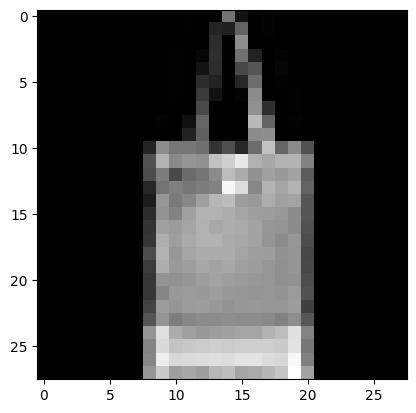

In [37]:
data_number = 13
prueba = X[data_number].detach().numpy().reshape(28, 28)
plt.imshow(prueba, cmap = "gray")

In [38]:
print(y[data_number])

print(Z[data_number])

tensor(8.)
tensor([-0.0006, -0.0010, -0.0006, -0.0006, -0.0005, -0.0008, -0.0009, -0.0009,
        -0.0006, -0.0006, -0.0004, -0.0008, -0.0005, -0.0007, -0.0006, -0.0005,
        -0.0006, -0.0007, -0.0008, -0.0003, -0.0007, -0.0007, -0.0006, -0.0008,
        -0.0007, -0.0004, -0.0010, -0.0006, -0.0010, -0.0006, -0.0006, -0.0004,
        -0.0010, -0.0006, -0.0008, -0.0002, -0.0006, -0.0007, -0.0008, -0.0010,
        -0.0006, -0.0010, -0.0009, -0.0006, -0.0003, -0.0008, -0.0008, -0.0013,
        -0.0008, -0.0008, -0.0005, -0.0006, -0.0006, -0.0010, -0.0007, -0.0008,
        -0.0005, -0.0007, -0.0003, -0.0004, -0.0004, -0.0010, -0.0005, -0.0007],
       grad_fn=<SelectBackward0>)


In [45]:
K_Z = kernel(Z, **kernel_param_X)
K_X = kernel(X, **kernel_param_X)
K_Y = binary_distance(y.unsqueeze(1), y.unsqueeze(1))

print(K_Z * K_Y)
print(K_X * K_Y)

tensor([[1., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], grad_fn=<MulBackward0>)
tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.3559, 0.0000],
        [0.0000, 1.0000, 0.0000,  ..., 0.3317, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.3317, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.3559, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]])


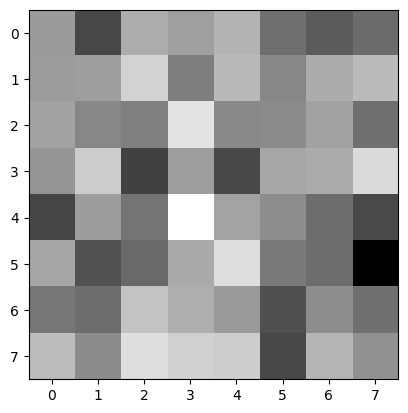

In [39]:
prueba_out = Z[data_number].detach().numpy().reshape(8, 8)
plt.imshow(prueba_out, cmap = "gray")

Training a MLP for classification with embeddings of the previous GNN model

In [30]:
class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, num_hidden_layers, output_size, lr, criterion, use_embeddings = True):
    super().__init__()
    
    self.criterion = criterion
    activation = nn.ReLU()
    self.MLP_layers = nn.ModuleList()
    layer = nn.Linear(input_size, hidden_size)
    nn.init.xavier_uniform(layer.weight)
    layer.bias.data.fill_(0.01)
    self.MLP_layers.append(layer)
    self.MLP_layers.append(activation)
    self.use_embeddings = use_embeddings

    for _ in range(num_hidden_layers - 1):

      layer = nn.Linear(hidden_size, hidden_size)
      nn.init.xavier_uniform(layer.weight)
      layer.bias.data.fill_(0.01)
      self.MLP_layers.append(layer)
      self.MLP_layers.append(activation)

    layer = nn.Linear(hidden_size, output_size)
    nn.init.xavier_uniform(layer.weight)
    layer.bias.data.fill_(0.01)
    self.MLP_layers.append(layer)
    self.MLP_layers.append(nn.Sigmoid())

    self.optimizer = Adam(self.parameters(), lr)

  def forward(self, x):
    for layer in self.MLP_layers:
      x = layer(x)

    return x
  
  def train_model(self, train_loader):

    self.train()

    epoch_losses = []
    epoch_accuracies = []

    for X, y in tqdm(train_loader):

      self.optimizer.zero_grad()
      if self.use_embeddings:
        with torch.no_grad():
          Z = model.encode(X)
        out = self.forward(Z)
      else:
        out = self.forward(X)
      
      loss = self.criterion(out, y.long())
      preds = torch.argmax(out, dim = 1)
      accuracy = torch.mean((preds == y.long()).float())
      epoch_losses.append(loss)
      epoch_accuracies.append(accuracy)
      loss.backward()
      self.optimizer.step()

    avg_loss = torch.mean(torch.Tensor(epoch_losses))
    avg_accuracy = torch.mean(torch.Tensor(epoch_accuracies))

    return avg_loss.item(), avg_accuracy.item()
  
  def test_model(self, data_loader):

    self.eval()

    test_losses = []
    test_accuracies = []

    for X, y in tqdm(data_loader):
        if self.use_embeddings:
          with torch.no_grad():
            Z = model.encode(X)
          out = self.forward(Z)
        else:
          out = self.forward(X)
        
        loss = self.criterion(out, y.long())
        preds = torch.argmax(out, dim = 1)
        accuracy = torch.mean((preds == y.long()).float())
        test_losses.append(loss)
        test_accuracies.append(accuracy)
    avg_loss = torch.mean(torch.Tensor(test_losses))
    avg_accuracy = torch.mean(torch.Tensor(test_accuracies))

    return avg_loss.item(), avg_accuracy.item()


In [31]:
lr_classif = 0.001
loss = nn.CrossEntropyLoss()
classif = MLP(latent_size, 16, 3, 10, lr_classif, loss, use_embeddings = True)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_2244\3759001460.py:9: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
C:\Users\Carlos\AppData\Local\Temp\ipykernel_2244\3759001460.py:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
C:\Users\Carlos\AppData\Local\Temp\ipykernel_2244\3759001460.py:24: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)


In [201]:
classif.parameters

<bound method Module.parameters of MLP(
  (criterion): CrossEntropyLoss()
  (MLP_layers): ModuleList(
    (0): Linear(in_features=64, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=10, bias=True)
    (7): Sigmoid()
  )
)>

In [32]:
epochs_classif = 200

In [33]:
# MLP training
for epoch in range(epochs_classif):
    print(f"epoch: {epoch + 1}/{epochs_classif}")
    avg_loss_train, avg_accuracy_train = classif.train_model(train_loader)

    # validation data
    avg_loss_val, avg_accuracy_val = classif.test_model(val_loader)

    print(f"avg_loss_train: {avg_loss_train:.4f}, avg_accuracy_train: {avg_accuracy_train:.4f}")
    print(f"avg_loss_val: {avg_loss_val:.4f}, avg_accuracy_val: {avg_accuracy_val:.4f}")

epoch: 1/200


100%|██████████| 88/88 [00:01<00:00, 82.25it/s]


avg_loss_train: 2.3026, avg_accuracy_train: 0.0962
avg_loss_val: 2.3026, avg_accuracy_val: 0.0998
epoch: 2/200


100%|██████████| 88/88 [00:01<00:00, 82.25it/s]


avg_loss_train: 2.3026, avg_accuracy_train: 0.0996
avg_loss_val: 2.3026, avg_accuracy_val: 0.1000
epoch: 3/200


100%|██████████| 88/88 [00:01<00:00, 82.40it/s]


avg_loss_train: 2.3026, avg_accuracy_train: 0.0968
avg_loss_val: 2.3026, avg_accuracy_val: 0.1003
epoch: 4/200


100%|██████████| 88/88 [00:01<00:00, 82.39it/s]


avg_loss_train: 2.3026, avg_accuracy_train: 0.0967
avg_loss_val: 2.3026, avg_accuracy_val: 0.0996
epoch: 5/200


100%|██████████| 88/88 [00:01<00:00, 82.32it/s]


avg_loss_train: 2.3026, avg_accuracy_train: 0.0983
avg_loss_val: 2.3026, avg_accuracy_val: 0.0996
epoch: 6/200


100%|██████████| 88/88 [00:01<00:00, 80.33it/s]


avg_loss_train: 2.3026, avg_accuracy_train: 0.0973
avg_loss_val: 2.3026, avg_accuracy_val: 0.0994
epoch: 7/200


 22%|██▏       | 175/788 [00:02<00:09, 67.07it/s]


KeyboardInterrupt: 

In [ ]:
# MLP testing
avg_loss_test, avg_accuracy_test = classif.test_model(test_loader)
print(f"avg_loss_test: {avg_loss_test:.4f}, avg_accuracy_test: {avg_accuracy_test:.4f}")

Comparing with MLP trained on input images

In [ ]:
classif_inputs = MLP(input_size, 16, 3, 10, lr_classif, loss, use_embeddings = False)

In [ ]:
# MLP training
for epoch in range(epochs_classif):
    print(f"epoch: {epoch + 1}/{epochs_classif}")
    avg_loss_train, avg_accuracy_train = classif_inputs.train_model(train_loader)

    # validation data
    avg_loss_val, avg_accuracy_val = classif_inputs.test_model(val_loader)
    
    print(f"avg_loss_train: {avg_loss_train:.4f}, avg_accuracy_train: {avg_accuracy_train:.4f}")
    print(f"avg_loss_val: {avg_loss_val:.4f}, avg_accuracy_val: {avg_accuracy_val:.4f}")

In [ ]:
# MLP testing
avg_loss_test, avg_accuracy_test = classif_inputs.test_model(test_loader)
print(f"avg_loss_test: {avg_loss_test:.4f}, avg_accuracy_test: {avg_accuracy_test:.4f}")

Save a model

In [ ]:
route = "models/x-x-24/"

# Create the directory if it does not exist
if not os.path.exists(route):
    os.makedirs(route)

# Paths for the files
encoder_weights_path = os.path.join(route, "encoder_weights.pth")
decoder_weights_path = os.path.join(route, "decoder_weights.pth")

# Save model weights
torch.save(model_encoder.state_dict(), encoder_weights_path)
torch.save(model_decoder.state_dict(), decoder_weights_path)

hyperparameters = {
    "learning_rate": lr,
    "batch_size": batch_size,
    "epochs": epochs,
    "latent_size": latent_size,
    "kernel_param_X": kernel_param_X,
    "kernel_param_Y": kernel_param_Y,
    "label_indep": label_indep, 
}

# Convert the dictionary to a JSON string
hyp_json = json.dumps(hyperparameters)

# Correct the file path and mode
hyperparameters_path = os.path.join(route, 'model_hyperparameters.txt')
with open(hyperparameters_path, 'w') as file:  # Changed mode to 'w'
    file.write(hyp_json)



Load a model

In [ ]:
encoder_weights_path = "GAE/models/Fashion_MNIST/7-5-24/encoder_weights.pth"
decoder_weights_path = "GAE/models/Fashion_MNIST/7-5-24/decoder_weights.pth"

model_encoder = GCNEncoder(input_size, latent_size)
model_decoder = GCNDecoder(latent_size, input_size)
model_encoder.load_state_dict(torch.load(encoder_weights_path))
model_decoder.load_state_dict(torch.load(decoder_weights_path))

optimizer = Adam(list(model_encoder.parameters()) + list(model_decoder.parameters()), lr = lr)
criterion = nn.MSELoss()
model = GAE(model_encoder, model_decoder, kernel_param_X, optimizer, criterion, label_indep, kernel_param_Y)